In [71]:
import os
import shutil 
from tqdm import tqdm
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
from torchvision import transforms, models

In [73]:
data_root = 'd:\\ustluga'

In [74]:
train_dir = 'train'
val_dir = 'val'

class_names = ['in', 'out']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 160/160 [00:00<00:00, 804.03it/s]


In [75]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224,scale=(0.8, 1.0)),
    transforms.ColorJitter(
    brightness=0.4,
    contrast=0.4,
    saturation=0.4,
    ),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


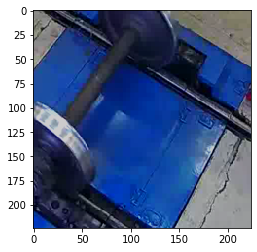

In [76]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

In [77]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

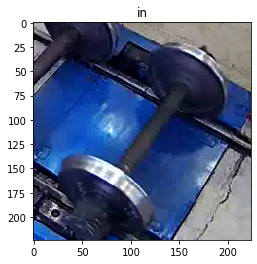

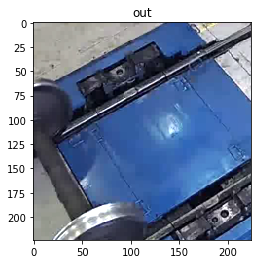

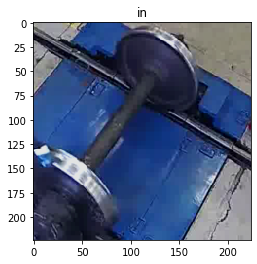

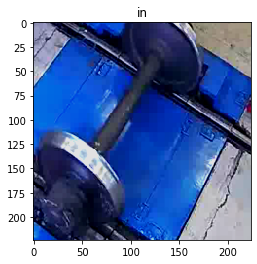

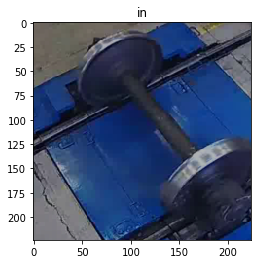

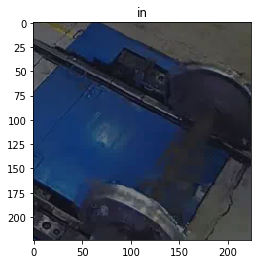

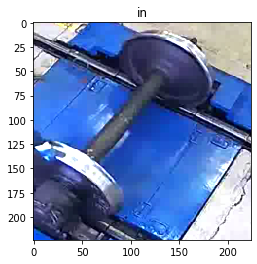

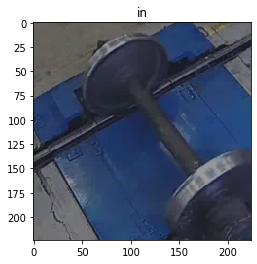

In [78]:
X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [79]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [80]:


model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



In [ ]:


train_model(model, loss, optimizer, scheduler, num_epochs=10);



Epoch 0/9:


100%|██████████| 41/41 [00:10<00:00,  3.84it/s]

train Loss: 0.5763 Acc: 0.6860



100%|██████████| 9/9 [00:02<00:00,  3.76it/s]

val Loss: 0.2646 Acc: 0.9306
Epoch 1/9:



100%|██████████| 41/41 [00:10<00:00,  3.84it/s]

train Loss: 0.3047 Acc: 0.9045



100%|██████████| 9/9 [00:02<00:00,  3.71it/s]

val Loss: 0.1680 Acc: 0.9444
Epoch 2/9:



100%|██████████| 41/41 [00:10<00:00,  3.83it/s]

train Loss: 0.2315 Acc: 0.9268



100%|██████████| 9/9 [00:02<00:00,  3.73it/s]

val Loss: 0.1359 Acc: 0.9583
Epoch 3/9:



100%|██████████| 41/41 [00:10<00:00,  3.85it/s]

train Loss: 0.1913 Acc: 0.9299



100%|██████████| 9/9 [00:02<00:00,  3.78it/s]

val Loss: 0.1228 Acc: 0.9444
Epoch 4/9:



100%|██████████| 41/41 [00:10<00:00,  3.79it/s]

train Loss: 0.2323 Acc: 0.9085



100%|██████████| 9/9 [00:02<00:00,  3.74it/s]

val Loss: 0.1160 Acc: 0.9444
Epoch 5/9:



100%|██████████| 41/41 [00:10<00:00,  3.80it/s]

train Loss: 0.1735 Acc: 0.9268



100%|██████████| 9/9 [00:02<00:00,  3.71it/s]

val Loss: 0.1049 Acc: 0.9444
Epoch 6/9:



  0%|          | 0/41 [00:00<?, ?it/s]

In [ ]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

In [15]:


class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)



In [19]:
torch.save(model, 'ustluga_cam6_resnet18_'+time.strftime('%H%M-%m%d%Y')+'.pt')

In [17]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


torch.Size([1, 3, 224, 224])

In [70]:
%%time
test_img = cv2.imread(path.join(data_root,'test\\camera60683.png'))
pil_im = Image.fromarray(test_img)
inp = val_transforms(pil_im).view(1,3,224,224)
inp.shape
inp = inp.to(device)
preds = model(inp)
torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()


Wall time: 15 ms


array([0.01039047], dtype=float32)

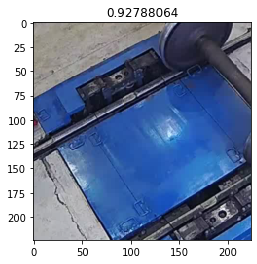

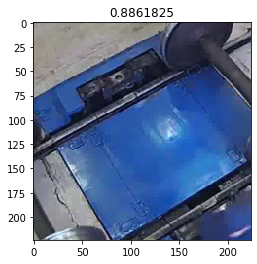

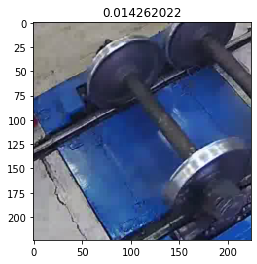

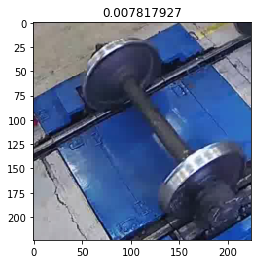

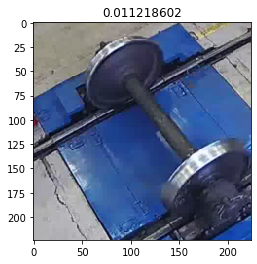

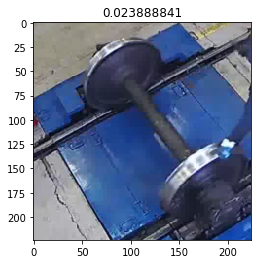

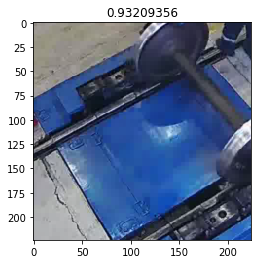

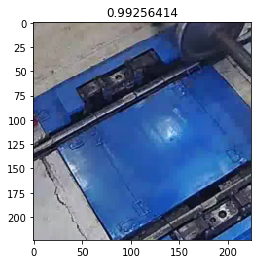

In [18]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)